In [1]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from tqdm import tqdm

### 0. The Bloch Sphere

Given one $\frac{1}{2}$-spin, its Hilbert space is $\mathbb{C}^2$ and we chose the basis $B = \{\uparrow, \downarrow\}$. Any wavefunction $\Psi$ can be parametrised by two angles $\theta, \phi$:

$$
\Psi = \cos \frac{\theta}{2} \uparrow + e^{i\phi} \sin \frac{\theta}{2} \downarrow
$$

The resulting wavefunctions form the manifold $M$. We inheret the metric structure of the ambient Hilbert space via the quantum information tensor. This results in a real Riemannian metric:

$$
g_{ij} = 2 \Re\, \langle \partial_i \Psi | \partial_j \Psi \rangle
$$

Here this leads to:

$$
ds^2 =  \frac{1}{2}d\theta^2 + 2 \sin \frac{\theta}{2} d\phi^2
$$

In a variational monte carlo simulation, we can raise and lower indices. The lowering part is more immediate, as the raising involves inverting the above metric. The lowering is written as:

$$
w_i = g_{ij} v^i
$$

We implement it in the folowing snippet:

In [2]:
def apply_g(primals, tangent):

    theta = primals[0]
    orig_shape = tangent.shape
    tangent = tangent.reshape(-1, 2, 1)

    g = jnp.array([[0.5, 0],[0, 2*jnp.sin(theta/2)**2]])
    res = jnp.matmul(g, tangent)
    return res.reshape(orig_shape)

In [3]:
param = jnp.array([0., 1.])
tangents = jnp.ones(shape = (20, 2))

cotangents = apply_g(param, tangents)
cotangents.shape

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(20, 2)

Using a numerical linear eqation solver (conjugate gradient), we can also raise indices:

In [4]:
def inverse_g(primals, cotangent):
    A = lambda tangents : apply_g(primals, tangents)
    return jax.scipy.sparse.linalg.cg(A, cotangent)[0]

In [5]:
tangents = inverse_g(param, cotangents)
tangents.shape

(20, 2)

### 1. Natural Gradient descent with Momentum

We aim to find the ground state of the system described by the Hamiltonian:

$$
H = -B \, S^{(x)}
$$

we can calculate the expected energy in our Bloch state $\Psi$ as a function of the parameters:

$$
E = \langle \Psi | H | \Psi \rangle = -\frac{B\hbar}{2}\sin\theta\cos\phi
$$

Instead of the regular natural gradient descent, which in continuous time is described as a curve $\gamma : \mathbb{R} \to M$ by the first-order differential equation
$$
\dot{\gamma}^i = -g^{ij}\partial_j E
$$
we employ a second order differential equation, which accounts for the momentum commonly found in many optimisers:
$$
\ddot{\gamma}^i + \Gamma^i_{jk} \dot{\gamma}^j \dot{\gamma}^k = -g^{ij}\partial_j E - \kappa \dot{\gamma}^i
$$
The parameter $\kappa$ controls the damping of the system, i.e. how much momentum lies in the optimisation. The left hand side of the equation is recognisable, as it is just the covariant acceleration of the curve $\gamma$ and thus the generalised second-oder time derivative which is informed by the geometry structure of the manifold. The Christoffel symbols $\Gamma$ appear only contracted in the form $\Gamma^i_{jk} \dot{\gamma}^j \dot{\gamma}^k$. We call this term the geodesic correction (also we write $\Gamma(\dot{\gamma},\dot{\gamma})$) and calculate it with the functions below:

In [6]:
def a(primals, gamma_dot):
    f = lambda primals : apply_g(primals, gamma_dot)
    res = jax.jvp(f, (primals,), (gamma_dot,))
    return res[1]

def b(primals, gamma_dot):
    f = lambda primals : jnp.sum(gamma_dot * apply_g(primals, gamma_dot))
    res = jax.vjp(f, primals)[1](jnp.array(1.))[0]
    return res

@jax.jit
def geodesic_correction(primals, gamma_dot):
    lower = 2 * a(primals, gamma_dot) - b(primals, gamma_dot)
    raised = inverse_g(primals, lower)
    return 0.5*raised

To calculate the energy and its natrural gradient, we use the following:

In [7]:
def calc_E(primals):
    orig_shape = primals.shape
    primals = primals.reshape((-1, 2))

    theta = primals[:,0]
    phi = primals[:,1]


    E = -jnp.sin(theta)*jnp.cos(phi)
    return E.reshape(orig_shape[0:-1])

@jax.jit
def calc_natural_gradient(primals):
    covect = jax.vjp(calc_E, primals)[1](jnp.array(1.))[0]
    return inverse_g(primals, covect)

### 1. Iterative Integration Scheme
The continuous time momentum equation will be discretised to obtain a recursive series, as one is familiar with for other optimisation algorithms.


The time derivatives can be discretised with finite differences. We take:

$$
\ddot{\gamma}(t) \approx \frac{1}{\epsilon^2}\left[\gamma(t + \epsilon) - 2 \gamma(t) + \gamma(t - \epsilon)\right]
$$

for the second derivative and
$$
\dot{\gamma}(t) \approx \frac{1}{\epsilon}\left[\gamma(t) - \gamma(t - \epsilon)\right]
$$
with $\epsilon$ being a small time step. The momentum equation becomes then:

$$
\gamma^i(t + \epsilon) = \gamma(t)^i - \epsilon^2g^{ij}\partial_j E + (1 - \kappa\epsilon)(\gamma^i(t) - \gamma^i(t-\epsilon)) - \Gamma^i_{jk}(\gamma^j(t)-\gamma^j(t-\epsilon))(\gamma^k(t)-\gamma^k(t-\epsilon))
$$

The momentum parameter $\beta$ is introduced via:
$$
\beta = 1- \kappa\epsilon
$$

In [38]:
dt = 0.3
T = 15
N_iter = int(T/dt) - 2

t = 0
kappa = 1.9
gamma = jnp.array([jnp.pi/2 - 0.5, 1.6])
gamma_dot = jnp.array([0.,0.])


ts = [t, t + dt]
gammas = [gamma - dt * gamma_dot, gamma]
for i in tqdm(range(2, N_iter)):

    delta_gam = gammas[i - 1] - gammas[i - 2]
    cor = geodesic_correction(gammas[i - 1], delta_gam)

    natural_grad = calc_natural_gradient(gammas[i - 1])


    gamma = gammas[i-1] - dt**2 * natural_grad +  (1 - kappa * dt) * delta_gam - cor
    t = ts[i - 1] + dt

    ts.append(t)
    gammas.append(gamma)

gammas = jnp.array(gammas)
ts = jnp.array(ts)

100%|██████████| 46/46 [00:00<00:00, 17446.24it/s]


Text(0.5, 1.0, 'Optimisation on the Bloch sphere: $H = -B\\,S^{(x)}$')

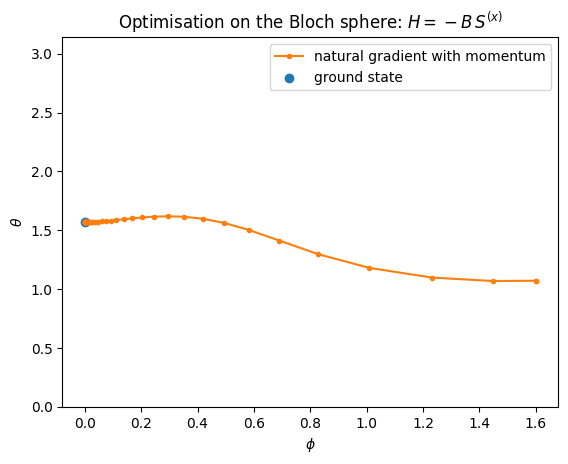

In [39]:
plt.plot(gammas[:,1], gammas[:, 0], color = "C1", marker = ".", label = "natural gradient with momentum")
plt.scatter(0, jnp.pi/2, label = "ground state")
plt.ylim(0, jnp.pi)
plt.ylabel("$\\theta$")
plt.xlabel("$\\phi$")
plt.legend()
plt.title("Optimisation on the Bloch sphere: $H = -B\\,S^{(x)}$")

---

### Implement these as functions

In [24]:
def optimise_momentum(gamma, N_iter = 150, dt = 0.1, kappa = 1.):
    gamma_dot = jnp.array([0.,0.])

    gammas = [gamma - dt * gamma_dot, gamma]
    for i in tqdm(range(2, N_iter)):
        delta_gam = gammas[i - 1] - gammas[i - 2]
        cor = geodesic_correction(gammas[i - 1], delta_gam)
        natural_grad = calc_natural_gradient(gammas[i - 1])
        gamma = gammas[i-1] - dt**2 * natural_grad +  (1 - kappa * dt) * delta_gam - cor
        gammas.append(gamma)

    gammas = jnp.array(gammas)

    return gammas

In [25]:
def optimise_natural_grad(gamma, N_iter = 150, dt = 0.1):
    gammas = [gamma]
    for i in tqdm(range(1, N_iter)):
        natural_grad = calc_natural_gradient(gammas[i - 1])
        gamma = gammas[i-1] - dt * natural_grad
        gammas.append(gamma)

    gammas = jnp.array(gammas)

    return gammas

In [26]:
def plot_traject(gammasA, gammasB, title = None, path = None):
    plt.figure()
    plt.plot(gammasA[:,1], gammasA[:, 0], color = "C0", marker = ".", label = "momentum")
    plt.plot(gammasB[:,1], gammasB[:, 0], color = "C1", marker = ".", label = "natural gradient")
    plt.scatter(0, jnp.pi/2, label = "ground state", color = "C3", marker = "X", zorder = 0)
    plt.ylim(0, jnp.pi)
    plt.ylabel("$\\theta$")
    plt.xlabel("$\\phi$")
    plt.legend()
    plt.title(title)

    if path:
        plt.savefig(path)

In [122]:
gammas_moment = optimise_momentum(jnp.array([0.5,1.]), dt = 0.2, kappa = 2.)
gammas_nat = optimise_natural_grad(jnp.array([0.5,1.]), dt = 0.05)

100%|██████████| 149/149 [00:00<00:00, 45237.15it/s]


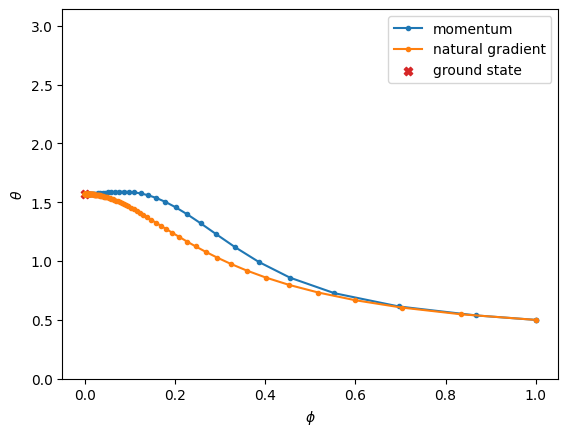

In [123]:
plot_traject(gammas_moment, gammas_nat)

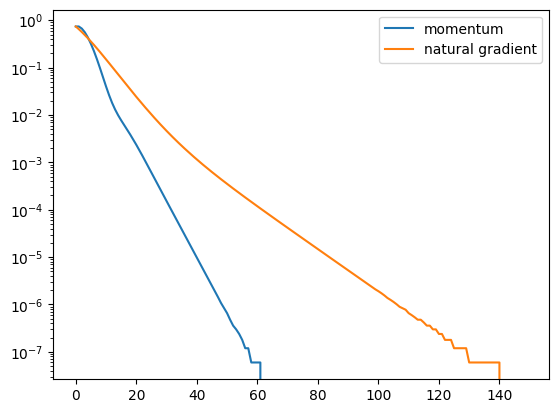

In [124]:
plt.plot(jnp.abs(calc_E(gammas_moment)+1), label = "momentum")
plt.plot(jnp.abs(calc_E(gammas_nat)+1), label = "natural gradient")

# plt.xscale("log")
plt.yscale("log")
plt.legend()
# plt.xlim(0, 40)

In [57]:
gammas.ndim

2